In [1]:
%matplotlib inline

In [2]:
import os
import sys
import numpy as np
import pickle
import json
import networkx as nx
import pandas as pd
import powerlaw
from scipy.stats import rankdata
from collections import defaultdict, Counter
from networkx.algorithms.community.quality import modularity as nx_modularity
import matplotlib.pyplot as plt

sys.path.append('../../pygkernels')
from pygkernels.data import Datasets
from pygkernels.measure import kernels, Kernel

In [3]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())

def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau

feature_inv = lambda x, power: (1 - (1 / x**power))

In [4]:
def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for _, classifier_accuracy in results.items():
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(-np.array(accuracies), method='min')):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

In [5]:
CACHE_ROOT = '/data/phd/pygkernels/cache/kkmeans_init_datasets'
dataset_names = [
    'dolphins',
    'football',
    'karate',
    'news_2cl1_0.1', 'news_2cl2_0.1', 'news_2cl3_0.1',
    'news_3cl1_0.1', 'news_3cl2_0.1', 'news_3cl3_0.1',
    'news_5cl1_0.1', 'news_5cl2_0.1', 'news_5cl3_0.1',
    'polblogs',
    'polbooks',
    'sp_school_day_1', 'sp_school_day_2',
    'cora_AI', 'cora_AI_ML', 'cora_DS_AT', 'cora_DB', 'cora_EC', 'cora_HA',
    'cora_HCI', 'cora_IR', 'cora_Net', 'cora_OS', 'cora_Prog',
    'eu-core',
    'eurosis'
]

In [6]:
param_norms = {
    'tau1|sqrtinv': {'min': 0.27, 'max': 0.94},
    'avg_degree|log': {'min': 0.86, 'max': 7.07},
    'modularity': {'min': -0.46, 'max': 0.84}
}

for param, norms in param_norms.items():
    param_norms[param]['width'] = norms['max'] - norms['min']
    
def normalize(param, param_name):
    return (param - param_norms[param_name]['min']) / param_norms[param_name]['width']

In [7]:
# allowed_measures = ['SCCT', 'logComm', 'logDF', 'RSP', 'Comm', 'NHeat']
allowed_measures = [kernel.name for kernel in kernels]

# Сравнение результатов на датасетах

Шаги:
* Формируем список всех датасетов и мер, а также их параметров: tau1, avg degree, modularity
* Открываем всё насчитанное
* Находим для каждого датасета лучший скор каждой меры
* Стратегия 1: выбираем для каждого датасета лучшую меру (upper bound)
* Стратегия 2: выбираем для всех датасетов общую лучшую меру (SCT или SCCT)
* Стратегия 3: выбираем для каждого датасета меру согласно его параметрам

In [8]:
with open('filtered_dataset.json', 'r') as f:
    lfr = json.load(f)
print(len(lfr))

for idx, lfr_item in enumerate(lfr):
    lfr[idx]['measure_best_results'] = {k: v for k, v in lfr[idx]['measure_best_results'].items() if k in allowed_measures}
    
idx_several_answers = [idx for idx, d in enumerate(lfr) 
                       if np.sum(np.max(np.array(list(d['measure_best_results'].values()))) == np.array(list(d['measure_best_results'].values()))) > 1]
idx_several_answers = set(idx_several_answers)

lfr = [d for idx, d in enumerate(lfr) if idx not in idx_several_answers]

lfr = [d for d in lfr if np.max(list(d['measure_best_results'].values())) > 0]
print(len(lfr))

7396
5935


In [9]:
buckets = defaultdict(list)
for lfr_item in lfr:
    modularity = lfr_item['estimated_params']['modularity']
    ari = np.max(list(lfr_item['measure_best_results'].values()))
    buckets[(modularity * 100 // 5) / 20].append(ari)
for key, items in buckets.items():
    buckets[key] = np.mean(items)

Text(0, 0.5, 'ARI')

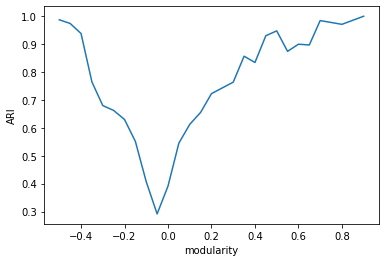

In [10]:
plt.plot(sorted(buckets.keys()), [buckets[k] for k in sorted(buckets.keys())])
plt.xlabel('modularity')
plt.ylabel('ARI')

In [11]:
data = defaultdict(dict)

In [12]:
datasets_holder = Datasets()
for dataset_name in dataset_names:
    (A, partition), info = datasets_holder[dataset_name]
    G = np2nx(A, partition)
    
    # Parameters
    avg_degree = 2 * G.number_of_edges() / G.number_of_nodes()
    node_degrees = [d for n, d in G.degree()]
    tau1 = power_law(node_degrees, 100)
    community_sizes = list(Counter(partition).values())
    modularity = nx_modularity(G, partition2communities(partition))
    data[dataset_name]['params'] = {
        'n': G.number_of_nodes(),
        'k': len(community_sizes),
        'tau1': tau1, 
        'tau1|sqrtinv': feature_inv(tau1, 0.5),
        'avg_degree': avg_degree,
        'avg_degree|log': np.log(avg_degree),
        'modularity': modularity
    }
    
    # Best measure according LFR
    lfr_distances = []
    for lfr_item in lfr:
        diff1 = np.abs(normalize(lfr_item['estimated_params']['tau1|sqrtinv'], 'tau1|sqrtinv') - 
                       normalize(data[dataset_name]['params']['tau1|sqrtinv'], 'tau1|sqrtinv'))
        diff2 = np.abs(normalize(lfr_item['estimated_params']['avg_degree|log'], 'avg_degree|log') - 
                       normalize(data[dataset_name]['params']['avg_degree|log'], 'avg_degree|log'))
        diff3 = np.abs(normalize(lfr_item['estimated_params']['modularity'], 'modularity') - 
                       normalize(data[dataset_name]['params']['modularity'], 'modularity'))
        dist = np.sqrt(diff1*diff1 + diff2*diff2 + diff3*diff3)
        lfr_distances.append((dist, lfr_item['measure_best_results']))
    lfr_distances = sorted(lfr_distances, key=lambda x: x[0])
   
    lfr_recomendation = {}
    for n_neighbors in range(1, 11):
        lfr_distances1 = lfr_distances[:n_neighbors]
        lfr_mean_ari = defaultdict(list)
        for dist, results in lfr_distances1:
            for measure_name, ari in results.items():
                lfr_mean_ari[measure_name].append(ari)
        for k, v in lfr_mean_ari.items():
            lfr_mean_ari[k] = np.nanmean(v)
        lfr_recomendation[f'{n_neighbors}nn'] = sorted([(k, v) for k, v in lfr_mean_ari.items() if k in allowed_measures], key=lambda x: -x[1])[0][0]
        lfr_recomendation[f'{n_neighbors}nn_aris'] = {k: v for k, v in lfr_mean_ari.items() if k in allowed_measures}
    data[dataset_name]['lfr_recomendation'] = lfr_recomendation
    
    # Results
    data[dataset_name]['results'] = {}
    best_dataset_kernel_name, best_dataset_kernel_ari = None, -1
    best_dataset_kernel_name_top6, best_dataset_kernel_ari_top6 = None, -1
    for kernel in kernels:
        dataset_kernel_results_mean = defaultdict(list)
        for i in range(7):
            filepath = f'{CACHE_ROOT}/by_column_and_kernel/{dataset_name}_{kernel.name}_results_0{i}.pkl'
            if os.path.exists(filepath):
                with open(filepath, 'rb') as f:
                    dataset_kernel_results = pickle.load(f)
                for param, param_results in dataset_kernel_results.items():
                    if len(param_results) > 0:
                        best_init = sorted(param_results, key=lambda x: -x['modularity'])[0]
                        dataset_kernel_results_mean[param].append(best_init['score_ari'])
                    else:
                        dataset_kernel_results_mean[param].append(0)
            else:
                print(filepath)
        for k, v in dataset_kernel_results_mean.items():
            dataset_kernel_results_mean[k] = np.mean(v)
        best_ari = np.max(list(dataset_kernel_results_mean.values()), initial=0)
        data[dataset_name]['results'][kernel.name] = best_ari

        if best_ari > best_dataset_kernel_ari:
            best_dataset_kernel_name, best_dataset_kernel_ari = kernel.name, best_ari
        elif best_ari == best_dataset_kernel_ari:
            if type(best_dataset_kernel_name) == list:
                best_dataset_kernel_name.append(kernel.name)
            else:
                best_dataset_kernel_name = [best_dataset_kernel_name, kernel.name]

        if kernel.name in allowed_measures:
            if best_ari > best_dataset_kernel_ari_top6:
                best_dataset_kernel_name_top6, best_dataset_kernel_ari_top6 = kernel.name, best_ari
            elif best_ari == best_dataset_kernel_ari_top6:
                if type(best_dataset_kernel_name_top6) == list:
                    best_dataset_kernel_name_top6.append(kernel.name)
                else:
                    best_dataset_kernel_name_top6 = [best_dataset_kernel_name_top6, kernel.name]

    data[dataset_name]['best_measure'] = {
        'name': best_dataset_kernel_name, 
        'ari': best_dataset_kernel_ari
    }
    
    data[dataset_name]['best_measure_top6'] = {
        'name': best_dataset_kernel_name_top6, 
        'ari': best_dataset_kernel_ari_top6
    }

Dataset dolphins not in cache; reload


/home/vlivashkin/.local/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


Dataset football not in cache; reload
Dataset karate not in cache; reload
Dataset news_2cl1_0.1 not in cache; reload
Dataset news_2cl2_0.1 not in cache; reload
Dataset news_2cl3_0.1 not in cache; reload
Dataset news_3cl1_0.1 not in cache; reload
Dataset news_3cl2_0.1 not in cache; reload
Dataset news_3cl3_0.1 not in cache; reload
Dataset news_5cl1_0.1 not in cache; reload
Dataset news_5cl2_0.1 not in cache; reload
Dataset news_5cl3_0.1 not in cache; reload
Dataset polblogs not in cache; reload
Dataset polbooks not in cache; reload
Dataset sp_school_day_1 not in cache; reload
Dataset sp_school_day_2 not in cache; reload
Dataset cora_AI not in cache; reload
Dataset cora_AI_ML not in cache; reload
Dataset cora_DS_AT not in cache; reload
Dataset cora_DB not in cache; reload
Dataset cora_EC not in cache; reload
Dataset cora_HA not in cache; reload
Dataset cora_HCI not in cache; reload
Dataset cora_IR not in cache; reload
Dataset cora_Net not in cache; reload
Dataset cora_OS not in cache; re

In [13]:
group_by_measure = defaultdict(list)
for dataset_name, results in data.items():
    for kernel_name, ari in results['results'].items():
        group_by_measure[kernel_name].append(ari)
meanari_real = {k: np.mean(v) for k, v in group_by_measure.items()}
meanari_real;

In [14]:
dataset_clf_acc = {dataset: results['results'] for dataset, results in data.items()}
ranks_real = {v: k for k, v in zip(*calc_avranks(dataset_clf_acc)[:2])}
ranks_real;

In [15]:
group_by_measure = defaultdict(list)
for dataset_name, results in data.items():
    for kernel_name, ari in results['lfr_recomendation']['5nn_aris'].items():
        group_by_measure[kernel_name].append(ari)
meanari_5nn = {k: np.mean(v) for k, v in group_by_measure.items()}
meanari_5nn;

In [16]:
dataset_clf_acc = {dataset: results['lfr_recomendation']['5nn_aris'] for dataset, results in data.items()}
ranks_5nn = {v: k for k, v in zip(*calc_avranks(dataset_clf_acc)[:2])}
ranks_5nn;

In [17]:
df = pd.DataFrame.from_records([{
    'name': kernel_name,
    'meanari_real': meanari_real[kernel_name],
    'ranks_real': ranks_real[kernel_name],
    'meanari_5nn': meanari_5nn[kernel_name],
    'ranks_5nn': ranks_5nn[kernel_name]
} for kernel_name in meanari_real.keys()])
df.to_excel('ranks_real_vs_5nn.xlsx')
df
# df.sort_values('ari', ascending=False)

KeyError: 'Katz'

In [ ]:
strategies_table = []
for dataset_name, results in data.items():
    strategies_table.append({
        'dataset_name': dataset_name,
        'n': results['params']['n'],
        'k': results['params']['k'],
        'tau1': results['params']['tau1'],
        'avg_degree': results['params']['avg_degree'],
        'modularity': results['params']['modularity'],
        'best_measure name': 'SCCT',
        'best_measure ari': results['results']['SCCT'],
    })
    
    for i in range(1, 11):
        strategies_table[-1].update({
            f'lfr_{i}nn name': results['lfr_recomendation'][f'{i}nn'],
            f'lfr_{i}nn ari': results['results'][results['lfr_recomendation'][f'{i}nn']]
        })
        
    strategies_table[-1].update({
        'upper_bound_top6 name': results['best_measure_top6']['name'],
        'upper_bound_top6 ari': results['best_measure_top6']['ari'],
        'upper_bound name': results['best_measure']['name'],
        'upper_bound ari': results['best_measure']['ari'],
    })

In [ ]:
df = pd.DataFrame(strategies_table)
df

In [ ]:
df.to_excel('strategies_table.xlsx')

In [ ]:
{k: {
    'tau1': v['params']['tau1'],
    'norm(tau1|sqrtinv)': normalize(v['params']['tau1|sqrtinv'], 'tau1|sqrtinv'),
    'avg_degree': v['params']['avg_degree'],
    'norm(avg_degree|log)': normalize(v['params']['avg_degree|log'], 'avg_degree|log'),
    'modularity': v['params']['modularity'],
    'norm(modularity)': normalize(v['params']['modularity'], 'modularity'),
    'top6': v['best_measure_top6']['name'],
#     'all': v['best_measure']['name']
} for k, v in data.items()}